# Проект: "Разработка системы рекомендаций банковских продуктов"
## Ноутбук для EDA и расчета рекомендаций
***

## Содержание
* [Инициализация](#step_0)
* [Подготовка инфраструктуры обучения моделей](#step_0)
* [Описание исходных данных](#step_1)
* [Анализ данных (EDA)](#step_2)
* [Функции для расчета MAP@k](#step_2)
* [Обучение базовой модели](#step_2)
* [Отбор признаков](#step_2)
* [Подбор гиперпараметров](#step_2)

## Инициализация <a id="step_0"></a>

In [1]:
# Убедимся, что работаем в нужном окружении
import sys

print(sys.executable)

c:\Users\Kirill_Nosov\_Repos\.venv\Scripts\python.exe


In [1]:
# Импортируем необходимые библиотеки

import os
import gc
from dotenv import load_dotenv

import boto3
from botocore.exceptions import ClientError

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_theme(style="whitegrid")

import joblib

#import scipy
from scipy.stats import pearsonr

from catboost import CatBoostClassifier, Pool
from category_encoders import CatBoostEncoder

from tqdm import tqdm
import datetime 

#import mlflow
#from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

import sklearn.preprocessing
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
    FunctionTransformer
)

#from autofeat import AutoFeatRegressor

#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

#import optuna
#from optuna.integration.mlflow import MLflowCallback

In [2]:
# Инциализируем генератор случайных чисел
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

In [2]:
# Отключаем предупреждения
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning))
#warnings.filterwarnings("ignore")

## Развертывание MLflow <a id="step_0"></a>

Для запуска MLflow нужно перейти в терминале в папку `/mlflow_server` и выполнить команду 

```sh run_mlflow_server.sh```

После этого устанавливаем параметры MLflow Tracking Server и MLflow Model Registry и задаем имя эксперимента (у нас будет один эксперимент на все этапы, которым будут соответствовать разные запуски).

In [ ]:
# Загружаем переменные окружения для S3-хранилища

load_dotenv()

os.environ["S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["S3_BUCKET_NAME"] = os.getenv("S3_BUCKET_NAME") 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

TRACKING_SERVER_HOST = '127.0.0.1' 
TRACKING_SERVER_PORT = 5000

tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_registry_uri(registry_uri) 

EXPERIMENT_NAME = 'mle-final-project'

## Описание исходных данных <a id="step_1"></a>

Файл [train_ver2.csv](https://disk.yandex.com/d/Io0siOESo2RAaA) содержит информацию о поведении 
клиентов банка за 1.5 года. 
Данные начинаются с 28.01.2015 и включают ежемесячные записи о продуктах, которые были у клиента, например, «кредитная карта», «сберегательный счет» и т.д. Необходимо предсказать, какие дополнительные продукты купит клиент в последнем месяце, оканчивающемся 28.06.2016, в дополнение к тому, что было у него 28.05.2016. 
Эти продукты представляют собой столбцы с именами ind_(xyz)_ult1, которые идут с 25-ой по 48-ю колонку в обучающих данных.

Список полей:
- fecha_dato - колонка для разделения таблицы,
- ncodpers - идентификатор пользователя,
- ind_empleado - статус занятости:
    - A — трудоустроен,
    - B — безработный (раньше работал),
    - F — иждивенец,
    - N — безработный,
    - P — пассивный (статус не определён),
- pais_residencia - страна проживания,
- sexo - пол, H - мужской, V - женский,
- age - возраст,
- fecha_alta - дата, когда клиент впервые заключил договор в банке,
- ind_nuevo - 1, если клиент зарегистрировался в течение последних 6 мес.,
- antiguedad - стаж клиента (в мес.),
- indrel:
    - 1 — основной клиент (т.е. основной владелец продукта - first/primary),
    - 99 — основной клиент в течение месяца, но не в последний день месяца,
- ult_fec_cli_1t - последняя дата, когда клиент был основным,
- indrel_1mes - тип клиента по отношению к продукту в начале месяца:
    - 1 — основной,
    - 2 — совладелец,
    - P — потенциальный,
    - 3 — бывший основной,
    - 4 — бывший совладелец,
- tiprel_1mes - тип клиента по отношению к банку в начале месяца:
    - A — активный,
    - I — неактивный,
    - P — бывший,
    - R — потенциальный,
- indresi - признак совпадения страны проживания клиента со страной банка, S - совпадает, N - не совпадает,
- indext - признак не совпадения страны рождения клиента со страной банка, S - не совпадает, N - совпадает,
- conyuemp - 1, если клиент является супругом(ой) работника банка,
- canal_entrada - канал, через который был привлечен клиент,
- indfall - признак актуальности счёта (англ. Deceased index, N/S),
- tipodom - тип адреса, 1 — основной адрес,
- cod_prov - код провинции (адреса клиента),
- nomprov - название провинции,
- ind_actividad_cliente - признак активности пользователя (1 — активный, 0 — неактивный),
- renta - валовый доход домохозяйства, 
- segmento - сегмент ('01 - TOP', '02 - PARTICULARES', '03 - UNIVERSITARIO'),

- ind_ahor_fin_ult1 - сберегательный счёт,
- ind_aval_fin_ult1 - банковская гарантия,
- ind_cco_fin_ult1 - текущие счета,
- ind_cder_fin_ult1 - деривативный счёт,
- ind_cno_fin_ult1 - зарплатный счет,
- ind_ctju_fin_ult1 - детский счёт,
- ind_ctma_fin_ult1 - особый счёт 3,
- ind_ctop_fin_ult1 - особый счёт,
- ind_ctpp_fin_ult1 - особый счёт 2,
- ind_deco_fin_ult1 - краткосрочный депозит,
- ind_deme_fin_ult1 - среднесрочный депозит,
- ind_dela_fin_ult1	- долгосрочный депозит,
- ind_ecue_fin_ult1	- цифровой счёт,
- ind_fond_fin_ult1	- фонды,
- ind_hip_fin_ult1 - ипотека,
- ind_plan_fin_ult1	- пенсионный план,
- ind_pres_fin_ult1	- кредит,
- ind_reca_fin_ult1	- налоговый счёт,
- ind_tjcr_fin_ult1	- кредитная карта,
- ind_valo_fin_ult1	- ценные бумаги,
- ind_viv_fin_ult1 - домашний счёт,
- ind_nomina_ult1 - зарплата,
- ind_nom_pens_ult1	- пенсии,
- ind_recibo_ult1 - прямой дебит

## Анализ данных (EDA) <a id="step_2"></a>

In [3]:
# Загружаем данные
data = pd.read_csv('../input_data/train_ver2.csv.zip')
data.head()

C:\Users\Kirill_Nosov\AppData\Local\Temp\ipykernel_8656\1194286340.py:2: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../input_data/train_ver2.csv.zip')


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


Из предупреждения "DtypeWarning: Columns (5,8,11,15)" следует, что значения в колонках 
- age, 
- antiguedad, 
- indrel_1mes,
- conyuemp

имеют разный тип, исправим это чуть позже.

In [5]:
# Исходные данные в транспонированном виде
data.head(5).T

,0,1,2,3,4
fecha_dato,2015-01-28,2015-01-28,2015-01-28,2015-01-28,2015-01-28
ncodpers,1375586,1050611,1050612,1050613,1050614
ind_empleado,N,N,N,N,N
pais_residencia,ES,ES,ES,ES,ES
sexo,H,V,V,H,V
age,35,23,23,22,23
fecha_alta,2015-01-12,2012-08-10,2012-08-10,2012-08-10,2012-08-10
ind_nuevo,0.0,0.0,0.0,0.0,0.0
antiguedad,6,35,35,35,35
indrel,1.0,1.0,1.0,1.0,1.0


In [4]:
# Проверяем типы колонок, кол-во строк и объем данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

In [5]:
# Смотрим % пустых значений
data.isnull().mean() * 100

fecha_dato                0.000000
ncodpers                  0.000000
ind_empleado              0.203220
pais_residencia           0.203220
sexo                      0.203732
age                       0.000000
fecha_alta                0.203220
ind_nuevo                 0.203220
antiguedad                0.000000
indrel                    0.203220
ult_fec_cli_1t           99.818330
indrel_1mes               1.097513
tiprel_1mes               1.097513
indresi                   0.203220
indext                    0.203220
conyuemp                 99.986752
canal_entrada             1.363829
indfall                   0.203220
tipodom                   0.203227
cod_prov                  0.685784
nomprov                   0.685784
ind_actividad_cliente     0.203220
renta                    20.475648
segmento                  1.387585
ind_ahor_fin_ult1         0.000000
ind_aval_fin_ult1         0.000000
ind_cco_fin_ult1          0.000000
ind_cder_fin_ult1         0.000000
ind_cno_fin_ult1    

Исходя из определения колонок cod_prov и nomprov, можно сделать вывод, что они дублируют друг друга, поэтому одну из них можно удалить. Удаляем cod_prov

In [7]:
# Удаляем признаковые колонки ult_fec_cli_1t и conyuemp, т.к. почти все значения в них пустые
data.drop(columns=['ult_fec_cli_1t','conyuemp'], inplace=True)

Исходя из определения колонок cod_prov и nomprov, можно сделать вывод, что они дублируют друг друга, поэтому одну из них можно удалить. Удаляем cod_prov

In [ ]:
# Удаляем колонку cod_prov
data.drop(columns=['cod_prov'], inplace=True)

In [6]:
# Заполняем пропуски в двух целевых колонках ind_nomina_ult1 и ind_nom_pens_ult1 нулями
# и приводим их к целому типу
data['ind_nomina_ult1'] = data['ind_nomina_ult1'].fillna(0).astype(int)
data['ind_nom_pens_ult1'] = data['ind_nom_pens_ult1'].fillna(0).astype(int)

У целого ряда признаков имеется одинаковый процент пропусков: 0.20322%. Посмотрим соответствующие строки

In [8]:
data[data['ind_empleado'].isnull()][['ind_empleado', 
                                     'pais_residencia', 
                                     'sexo',
                                     'fecha_alta',
                                     'ind_nuevo',
                                     'indrel',
                                     'indresi',
                                     'indext',
                                     'indfall',
                                     'tipodom',
                                     'ind_actividad_cliente']]

,ind_empleado,pais_residencia,sexo,fecha_alta,ind_nuevo,indrel,indresi,indext,indfall,tipodom,ind_actividad_cliente
261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3775976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что все эти признаки незаполнены у одних и тех же строк. Поскольку доля этих строк небольшая, 
а заполнение пустых значений обычными способами для некоторых признаков не имеет смысла (н-р, пол клиента
может быть заполнен в одном месяце, но не заполнен в другом, поэтому брать моду по всему датасету некорректно), 
то будет проще удалить эти строки.

In [8]:
# Удаляем строки, у которых одновременно незаполнены все признаки, указанные выше
data.drop(data[data['ind_empleado'].isnull()].index, inplace=True)

В категориальной колонке indrel_1mes присутствуют как числа, так и строки, при этом она имеет тип object.
Посмотрим на набор значений в этой колонке

In [8]:
# Значения в колонке indrel_1mes
data['indrel_1mes'].unique()

array([1.0, 3.0, 2.0, nan, '1.0', '1', '3', '3.0', '2.0', '4.0', 'P', '4',
       4.0, '2'], dtype=object)

Приводим значения в колонке indrel_1mes к одному типу и формату

In [9]:
# Заменяем на соответствующие строковые значения
data['indrel_1mes'].replace({1.0:'1', 
                             3.0:'3', 
                             2.0:'2', 
                             '1.0':'1', 
                             '3.0': '3', 
                             '2.0':'2', 
                             '4.0':'4', 
                             4.0:'4'}, inplace=True)

In [10]:
# Смотрим результат
data['indrel_1mes'].unique()

array(['1', '3', '2', nan, '4', 'P'], dtype=object)

Заполним пропуски в категориальных признаках. Сначала убедимся, что если у клиентов пропущены значения в каком-то одном месяце, то и во всех остальных записях этих клиентов соответтсвующие признаки будут отсутствовать. 
Поэтому для заполнения таких пропусков не нужно брать данные только по данному клиенту.

In [15]:
# Категориальные признаки с пропущенными значениями
categ_cols_with_nans = ['sexo', 
                        'indrel_1mes',
                        'tiprel_1mes',
                        'tipodom',
                        'canal_entrada',
                        'nomprov',
                        'segmento']

In [16]:
# id клиентов, у которых есть пропуски в соответствующих категориальных признаках
ncodpers_with_empty_categ = data[data[categ_cols_with_nans].isnull()]['ncodpers'].unique()

In [ ]:
# Смотрим info по всем записям таких клиентов
data[data.ncodpers.isin(ncodpers_with_empty_categ)][categ_cols_with_nans].info()

Видим, что непустых значений тоже нет, значит можно заполнить пропуски обычным способом, т.е.
брать, н-р, моды по всему датасету.

In [ ]:
# Заполняем пропуски в оставшихся категориальных признаках
for col in categ_cols_with_nans:
    fill_value = data[col].mode().iloc[0]
    data[col].fillna(value=fill_value, inplace=True)

В датасете имеется 3 числовых признака: age, antiguedad и renta,
остальные признаки с типом float64 являются категориальными. 
При этом у колонок age и antiguedad указан тип object. 
Проверим значения в этих колонках

In [9]:
data['age'].unique()

array([' 35', ' 23', ' 22', ' 24', ' 65', ' 28', ' 25', ' 26', ' 53',
       ' 27', ' 32', ' 37', ' 31', ' 39', ' 63', ' 33', ' 55', ' 42',
       ' 58', ' 38', ' 50', ' 30', ' 45', ' 44', ' 36', ' 29', ' 60',
       ' 57', ' 67', ' 47', ' 34', ' 48', ' 46', ' 54', ' 84', ' 15',
       ' 12', '  8', '  6', ' 83', ' 40', ' 77', ' 69', ' 52', ' 59',
       ' 43', ' 10', '  9', ' 49', ' 41', ' 51', ' 78', ' 16', ' 11',
       ' 73', ' 62', ' 66', ' 17', ' 68', ' 82', ' 95', ' 96', ' 56',
       ' 61', ' 79', ' 72', ' 14', ' 19', ' 13', ' 86', ' 64', ' 20',
       ' 89', ' 71', '  7', ' 70', ' 74', ' 21', ' 18', ' 75', '  4',
       ' 80', ' 81', '  5', ' 76', ' 92', ' 93', ' 85', ' 91', ' 87',
       ' 90', ' 94', ' 99', ' 98', ' 88', ' 97', '100', '101', '106',
       '103', '  3', '  2', '102', '104', '111', '107', '109', '105',
       '112', '115', '110', '116', '108', '113', 37, 81, 43, 30, 45, 41,
       67, 59, 46, 36, 47, 69, 39, 44, 40, 38, 34, 42, 31, 35, 48, 60, 54,
       51, 3

In [10]:
data['antiguedad'].unique()

array(['      6', '     35', '     34', '     33', '     31', '     21',
       '     16', '     27', '      9', '     22', '     13', '     29',
       '      8', '     11', '     10', '     28', '     24', '      7',
       '     25', '     14', '     26', '     12', '     23', '      1',
       '     18', '      4', '      3', '     17', '     32', '     30',
       '     20', '     15', '     19', '    157', '     36', '      5',
       '     40', '     38', '     37', '     39', '      0', '      2',
       '     47', '     44', '     42', '     46', '     45', '     43',
       '     41', '     57', '     48', '     52', '     49', '     50',
       '     56', '     58', '     51', '     55', '     54', '     53',
       '     59', '     62', '     61', '     60', '     63', '    139',
       '    165', '    118', '    164', '    142', '     94', '    159',
       '    143', '    105', '    151', '    162', '    137', '    150',
       '    128', '    122', '    156', '    119', 

Пропусков нет, но есть строковые и экстремальные значения. Приводим их к числовому типу

In [10]:
# Приводим age и antiguedad к float
data['age'] = data['age'].astype('float64')
data['antiguedad'] = data['antiguedad'].astype('float64')

Заполним пропуски в renta. Аналогично категориальным признакам выше, легко проверить, что
для заполнения renta можно брать аггрегированные статистики, а не данные только по данному клиенту.

In [ ]:
# Берем id клиентов, у которых есть пропуски в renta
ncodpers_with_empty_renta = data[data.renta.isnull()]['ncodpers'].unique()

In [ ]:
# Смотрим info по всем записям таких клиентов
data[data.ncodpers.isin(ncodpers_with_empty_renta)]['renta'].info() 

Видим, что все renta у таких клиентов пустые, поэтому заполняем пропуски модами
(используем моды, т.к. у renta есть выбросы, которые придется удалить, о чем будет сказано чуть ниже).
Перед расчетом мод проверим, сильно ли они отличаются от провинции к провинции

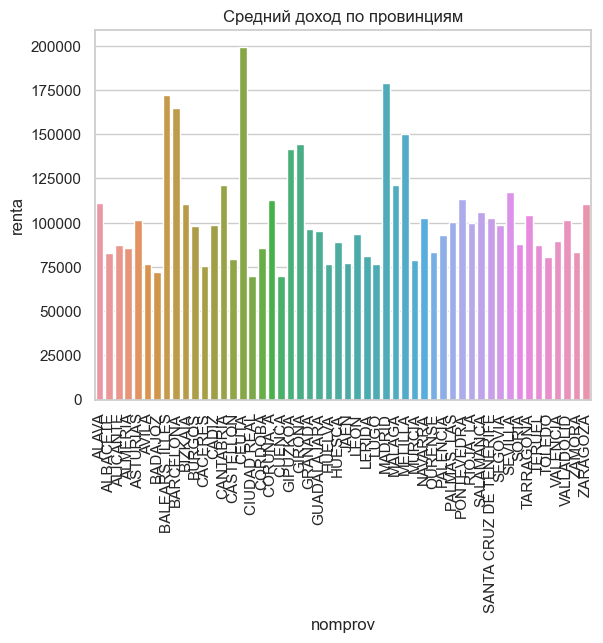

In [12]:
agg_by_prov = pd.DataFrame(data.groupby("nomprov")["renta"].agg('mean')).reset_index() 
sns.barplot(data=agg_by_prov, x='nomprov', y='renta') 
plt.title(f'Средний доход по провинциям')
plt.xticks(rotation='vertical')
plt.show()


Видим, что доходы в провинциях действительно могут значительно оличаться

240203

<class 'pandas.core.series.Series'>
Index: 2766641 entries, 4 to 13647308
Series name: renta
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 42.2 MB


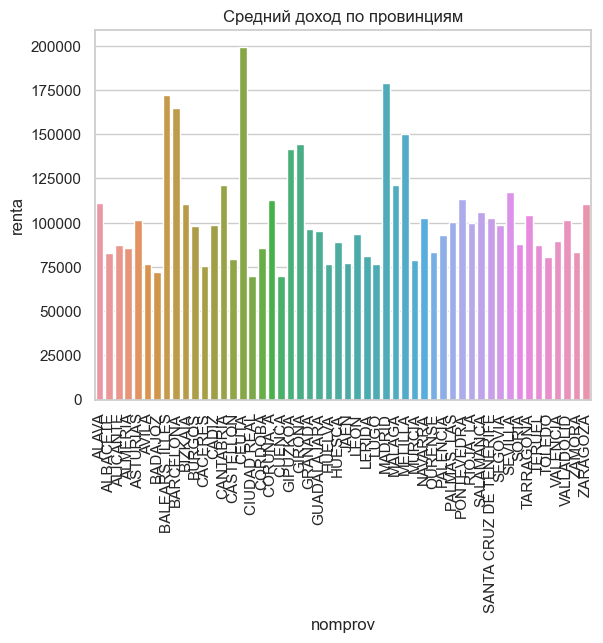

In [13]:
agg_by_prov = pd.DataFrame(data.groupby("nomprov")["renta"].agg('mean')).reset_index() 
sns.barplot(data=agg_by_prov, x='nomprov', y='renta') 
plt.title(f'Средний доход по провинциям')
plt.xticks(rotation='vertical')
plt.show()

Действительно, доход зависит от провинции, поэтому будем считать моды в разрезе по данному признаку

In [25]:
# Заполняем пропуски в renta 
data['renta'].fillna(value=data['renta'].mode().iloc[0], inplace=True)

Делаем аналогичную проверку для оставшихся категориальных признаков с пропущенными значениями

In [27]:
# Оставшиеся категориальные признаки с пропущенными значениями
categ_cols_with_nans = ['sexo', 
                        'indrel_1mes',
                        'tiprel_1mes',
                        'tipodom',
                        'canal_entrada',
                        'nomprov',
                        'segmento']

In [36]:
# id клиентов, у которых есть пропуски в соответствующих категориальных признаках
ncodpers_with_empty_categ = data[data[categ_cols_with_nans].isnull()]['ncodpers'].unique()

In [37]:
# Смотрим info по всем записям таких клиентов
data[data.ncodpers.isin(ncodpers_with_empty_categ)][categ_cols_with_nans].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sexo           0 non-null      object 
 1   indrel_1mes    0 non-null      object 
 2   tiprel_1mes    0 non-null      object 
 3   canal_entrada  0 non-null      object 
 4   cod_prov       0 non-null      float64
 5   nomprov        0 non-null      object 
 6   segmento       0 non-null      object 
dtypes: float64(1), object(6)
memory usage: 0.0+ bytes


Видим, что непустых значений тоже нет, значит можно заполнить пропуски обычным способом, т.е.
брать, н-р, моды по всему датасету.

In [28]:
# Заполняем пропуски в оставшихся категориальных признаках
for col in categ_cols_with_nans:
    fill_value = data[col].mode().iloc[0]
    data[col].fillna(value=fill_value, inplace=True)

Проанализируем выбросы у количественных признаков

In [29]:
# Отмечаем выбросы

# Количественные признаки
num_cols = ['age', 'antiguedad', 'renta']

threshold = 1.5
outliers = pd.DataFrame()

print('Кол-во выбросов:')
for col in num_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    margin = threshold * IQR
    lower = Q1 - margin
    upper = Q3 + margin
    outliers[col] = ~data[col].between(lower, upper)

Кол-во выбросов:
age: 113291
antiguedad: 38
renta: 1147147


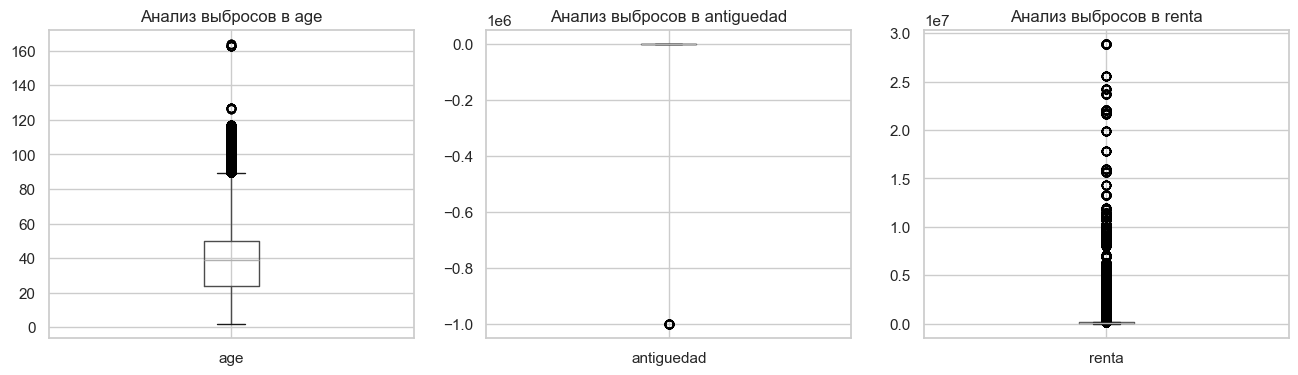

In [19]:
# Строим boxplots

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,4)) 
data[['age']].boxplot(ax=ax1)
ax1.set_title('Анализ выбросов в age')
data[['antiguedad']].boxplot(ax=ax2)
ax2.set_title('Анализ выбросов в antiguedad')
data[['renta']].boxplot(ax=ax3)
ax3.set_title('Анализ выбросов в renta')
plt.show()

In [39]:
# Проверим % уникальных клиентов с выбросами

print(f"% уникальных клиентов с выбросами в age: {data[outliers['age']]['ncodpers'].nunique() / data['ncodpers'].nunique() * 100:.2f}%")
print(f"% уникальных клиентов с выбросами в antiguedad: {data[outliers['antiguedad']]['ncodpers'].nunique() / data['ncodpers'].nunique() * 100:.4f}%")
print(f"% уникальных клиентов с выбросами в renta: {data[outliers['renta']]['ncodpers'].nunique() / data['ncodpers'].nunique() * 100:.2f}%")

% уникальных клиентов с выбросами в age: 0.88%
% уникальных клиентов с выбросами в antiguedad: 0.0003%
% уникальных клиентов с выбросами в renta: 7.87%


Таким образом, выбросы у age и antiguedad можно удалить, т.к. это действительно экстремальные значения, 
которые практически не встречаются в реальной жизни, и, кроме того, они попадаются у относительно небольшого кол-ва клиентов. 

Что касается больших значений renta, то они имеют место почти у 10% людей, но если посмотреть максимумы по сегментам, то увидим противоречие, т.к. максимальные доходы в топ-сегменте окажутся ниже. Значит эти 
значения действительно являются выбросами и их можно удалить

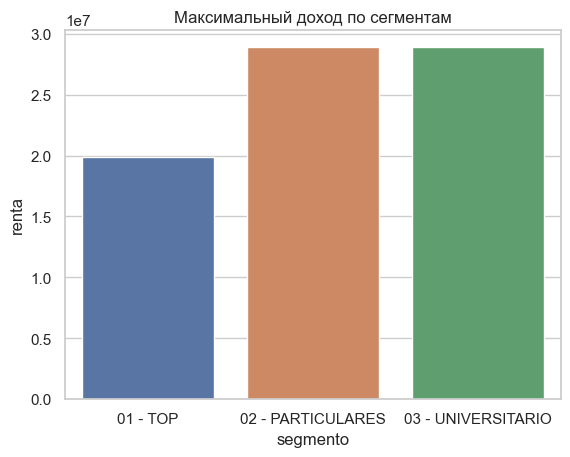

In [41]:
agg_by_segm = pd.DataFrame(data.groupby("segmento")["renta"].agg('max')).reset_index() 
sns.barplot(data=agg_by_segm, x='segmento', y='renta') 
plt.title(f'Максимальный доход по сегментам')
plt.show()

In [20]:
# Удаляем выбросы в age, antiguedad и renta
outliers = outliers[['age', 'antiguedad', 'renta']].any(axis=1)
data = data[~outliers]

Посмотрим на динамику изменения количества уникальных клиентов. Это позволит выявить возможные изменения в характере данных, н-р, из-за наличия сезонности, а также сократить датасет до приемлемого размера (1.5-2Gb)

In [24]:
# Агрегируем кол-во уникальных клиентов по месяцам
agg_by_date = data.groupby("fecha_dato")\
    .agg(unique_clients=('ncodpers', 'nunique')).reset_index()

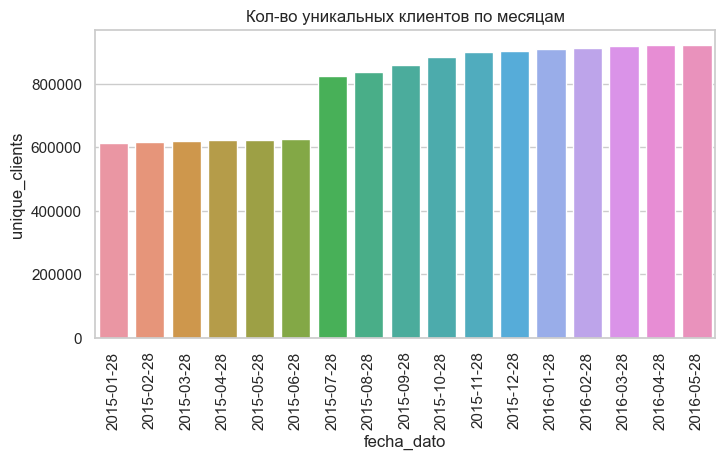

In [26]:
# Строим барплот 

plt.figure(figsize=(8,4))
sns.barplot(data=agg_by_date, x='fecha_dato', y='unique_clients')\
    .set_title('Кол-во уникальных клиентов по месяцам')
plt.xticks(rotation='vertical')
plt.show()

Видим, что наблюдается резкое изменение количества клиентов в середине 2015 г., 
поэтому имеет смысл оставить только данные, начиная с июля 2015 г.

In [21]:
# Оставляем данные, начиная с ноября 2015 г.
data = data.query("fecha_dato >= '2015-07-28'")

In [17]:
# Смотрим, какого размера получились данные после удаления части строк
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9786333 entries, 3776494 to 13647308
Data columns (total 45 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    float64
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             float64
 9   indrel                 float64
 10  indrel_1mes            object 
 11  tiprel_1mes            object 
 12  indresi                object 
 13  indext                 object 
 14  canal_entrada          object 
 15  indfall                object 
 16  tipodom                float64
 17  cod_prov               float64
 18  ind_actividad_cliente  float64
 19  renta                  float64
 20  segmento               object 
 21  ind_ahor_fin_ult1      int64  
 22  ind_aval_fin_ult

In [18]:
# Кол-во уникальных клиентов
data['ncodpers'].nunique()

942289

Выделим отдельно бинарные и небинарные категориальные признаки, чтобы потом применять
к ним отдельные энкодеры

In [25]:
# Бинарные категориальные признаки
bin_cat_cols = ['sexo', 
                'ind_nuevo', 
                'indresi', 
                'indrel',
                'indext', 
                'indfall', 
                'tipodom', 
                'ind_actividad_cliente']

# Небинарные категориальные признаки
non_bin_cat_cols = ['ind_empleado', 
                    'pais_residencia',
                    'indrel_1mes',
                    'tiprel_1mes',
                    'canal_entrada',
                    'cod_prov',
                    'segmento']

Убедимся, что у бинарных признаков имеется по 2 различных значения 

In [26]:
data[bin_cat_cols].nunique()

sexo                     2
ind_nuevo                2
indresi                  2
indrel                   2
indext                   2
indfall                  2
tipodom                  1
ind_actividad_cliente    2
dtype: int64

Видим, что признак tipodom является константным, поэтому его можно удалить 

In [27]:
data.drop(columns=['tipodom'], inplace=True)

Переходим к целевым переменным.

In [21]:
# Список исходных целевых колонок
target_cols = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
               'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
               'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
               'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
               'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
               'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

Оценим, сколько продуктов одновременно бывает у клиентов 

In [ ]:
# Просуммируем целевые переменные по горизонтали, чтобы оценить общее кол-во продуктов у каждого клиента
targets_sums_horiz = data.iloc[:, 22:].sum(axis=1)
targets_sums_horiz.unique()

In [ ]:
# Строим гистограмму распределения кол-ва продуктов у клиентов
plt.hist(targets_sums_horiz)
plt.title("Распределение кол-ва продуктов у клиентов")
plt.show()

Т.е. в основном клиенты пользуются одним продуктом, но встречаются и случаи с 2-8. 

Перейдем к одной целевой переменной, т.е. заменим задачу классификации с Multi-Class на Multi-Label. Для этого конкатенируем исходные целевые столбцы и закодируем получившиеся последовательности из 1 и 0 

In [ ]:
# Приводим значения 1/0 в исходных целевых колонках к строковому типу
data[target_cols] = data[target_cols].astype(str)

In [ ]:
# Конкатенируем исходные целевые колонки в новую колонку 
data['target'] = data[target_cols].agg(''.join, axis=1)

In [ ]:
# Смотрим, что получилось
data['target']

In [ ]:
# Кол-во уникальных таргетов
data['target'].nunique()

Оценим популярность продуктов для генерации рекомендаций по умолчанию. Для этого сначала разобьем датасет на train и test, где test будет содержать данные за последний месяц, т.е. за май 2016 г.

In [31]:
# Разделяем датасет на train и test
train_test_split_idx = data["fecha_dato"] <= "2016-04-28"
data_train = data[train_test_split_idx]
data_test = [~train_test_split_idx]

In [47]:
# Просуммируем целевые переменные по вертикали, чтобы оценить популярность продуктов
items = data_train.iloc[:, 21:].sum(axis=0)
items.sort_values(inplace=True, ascending=False)

In [48]:
# Формируем таблицу продуктов, отсортированных по встречаемости в train
items = pd.DataFrame(items)\
    .reset_index()\
        .rename(columns={'index': 'name'})\
            .rename(columns={0: 'clients'})\
                .reset_index()\
                    .rename(columns={'index': 'rank'})\
                        .reset_index()\
                            .rename(columns={'index': 'item_id'})

items['rank'] += 1
items

,item_id,rank,name,events_cnt
0,0,1,ind_cco_fin_ult1,5413699
1,1,2,ind_recibo_ult1,1049140
2,2,3,ind_ctop_fin_ult1,1001428
3,3,4,ind_ecue_fin_ult1,675684
4,4,5,ind_cno_fin_ult1,663556
5,5,6,ind_nom_pens_ult1,486672
6,6,7,ind_nomina_ult1,447491
7,7,8,ind_reca_fin_ult1,431700
8,8,9,ind_tjcr_fin_ult1,357306
9,9,10,ind_ctpp_fin_ult1,340643


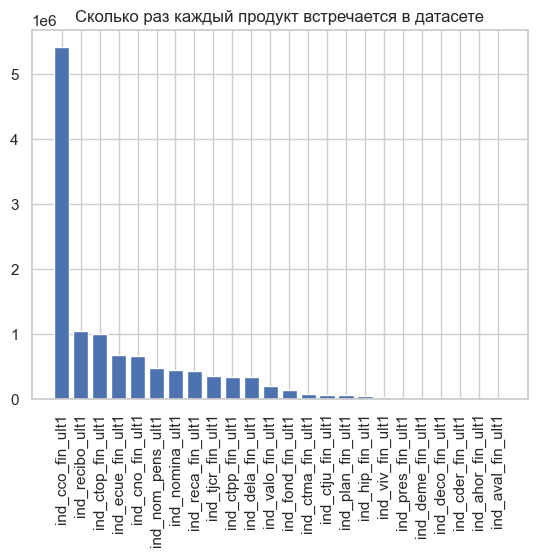

In [45]:
# Строим гистограмму встречаемости продуктов во всем датасете
plt.bar(items.name, items.events_cnt)
plt.xticks(rotation='vertical')
plt.title("Сколько раз каждый продукт встречается в датасете")
plt.show()

Таким образом, текущие счета являются наиболее популярными. Сохраняем эти данные в файл

In [50]:
items.to_parquet('../data/items.parquet')

Переименовываем очищенный датасет в events и сохраняем его в отдельном файле

In [25]:
events = data
events.to_parquet("../data/events.parquet")

### Выводы по этапу EDA

- Удалили признак nomprov, т.к. он дублирует cod_prov; 
- Проверили исходные данные на наличие пропусков, некорректных типов и  
значений:
    - Удалили признаки ult_fec_cli_1t и conyuemp, т.к. у них почти 100% пропусков;
    - В двух целевых колонках (ind_nomina_ult1 и ind_nom_pens_ult1) заполнили пропуски нулями 
    и привели их к целому типу;
    - В признаке indrel_1mes привели значения к одному типу и формату;
    - Удалили строки, в которых одновременно незаполнены 11 признаков;
    - Строковые значения у числовых признаков и сами эти признаки привели к типу float;
    - Пропуски у числовых признаков заполнили средними значениями,
    у категориальных - модами. При этом убедились, что взятие этих статистик по всему 
    датасету корректно, т.к. если данные признаки незаполнены в одном месяце, 
    то их нет и в остальных записях соответствующих клиентов;
- Удалили выбросы у числовых признаков age и antiguedad, большие значения у renta
решили оставить, т.к. они встречаются у значительного количества клиентов, и, скорее всего,
соответствуют премиальному сегменту;
- Обнаружили изменения в характере распределения количества клиентов по времени,
поэтому оставили только данные с июля 2017, что позволило также
сократить датасет с ~5Gb до ~3.3Gb;
- Проанализировали популярность продуктов (самым популярными оказались текущие счета), соответствующие данные
сохранили в файле `data/items.parquet` для формирования рекомендаций по умолчанию;
- Очищенные данные сохранили в файле `data/events.parquet`